# 구진모(32130775)

실제자료인 New Thyroid 및 Pima 자료를  이용하여 분류용 RBM의 두 가지 학습 알고리즘인 기존의 CD 알고리즘과 
평균 CD 알고리즘의 분류성능을 비교하시오. 분류성능의 비교를 위해 정확도와 AUC를 사용하시오

- 2개의 자료는 UCI 기계학습저장소 http://archive.ics.uci.edu/ml 에서 구하면 됩니다.

- 모멘텀을 고려한 알고리즘을 사용하시오.

- 각 자료를 임의로 3등분하여 2등분은 훈련자료로 1등분은 검정자료로 사용하시오.

### random_state = 32130775

In [5]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from imblearn.over_sampling import SMOTE
from __future__ import print_function

In [6]:
from scipy.ndimage import convolve
from sklearn import linear_model, datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline
from numpy.random import multinomial
from scipy.special import expit
from scipy.misc import logsumexp
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import gen_even_slices, check_array
from sklearn.utils.extmath import safe_sparse_dot
from sklearn.utils.validation import check_is_fitted, NotFittedError
from scipy.sparse import csr_matrix, issparse

In [4]:
New_Thyroid = pd.read_csv('C:/Users/wlsah/Desktop/New_Thyroid.csv')
Pima = pd.read_csv('C:/Users/wlsah/Desktop/Pima.csv')

In [5]:
New_Thyroid.head(3)

,class,T3,Tsthyroxin,Tstrii,bTSH,madT
0,1,107,10.1,2.2,0.9,2.7
1,1,113,9.9,3.1,2.0,5.9
2,1,127,12.9,2.4,1.4,0.6


In [6]:
Pima.head(3)

,N.pregnat,Pgc2,Dbp,Tsft(mm),insulin,Bodymass,Dpf,Age,class
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [7]:
New_Thyroid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 6 columns):
class         215 non-null int64
T3            215 non-null int64
Tsthyroxin    215 non-null float64
Tstrii        215 non-null float64
bTSH          215 non-null float64
madT          215 non-null float64
dtypes: float64(4), int64(2)
memory usage: 10.2 KB


In [8]:
Pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
N.pregnat    768 non-null int64
Pgc2         768 non-null int64
Dbp          768 non-null int64
Tsft(mm)     768 non-null int64
insulin      768 non-null int64
Bodymass     768 non-null float64
Dpf          768 non-null float64
Age          768 non-null int64
class        768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### 그래프

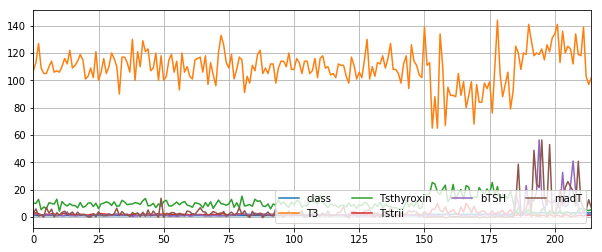

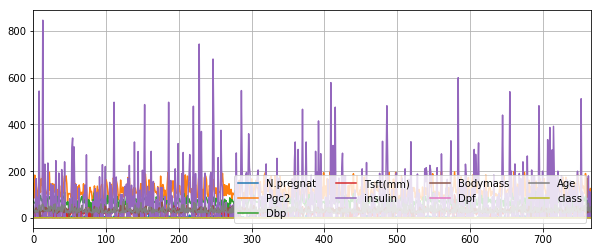

In [9]:
#변수 그래프
New_Thyroid.plot(figsize=(10,4)).legend(ncol=4,loc=4,frameon=True)
plt.grid(True)
plt.show()

# 변수 그래프
Pima.plot(figsize=(10,4)).legend(ncol=4,loc=4,frameon=True)
plt.grid(True)
plt.show()

# RBM model

In [7]:
class RBM(BaseEstimator, TransformerMixin):
    def __init__(self, n_components, n_iter=5, optimizer = 'pcd', learning_rate= 1e-2,
                 momentum = 0.5, batch_size=10, l2_penalty = 1e-3, n_gibbs_samples = 1,
                 compute_score = False, verbose = False,random_Stae=None):
        self.n_components     = n_components
        self.n_iter           = n_iter
        self.random_state = 32130775
        self.learning_rate    = learning_rate
        self.momentum         = momentum
        self.batch_size       = batch_size
        self.l2_penalty       = l2_penalty
        self.n_gibbs_samples  = n_gibbs_samples
        self.verbose          = verbose  
        if optimizer not in ['cd','pcd']:
            raise ValueError(( "Parameter optimizer can be either 'pcd' or "
                               "'cd', observed : {0}").format(optimizer))
        self.optimizer        = optimizer
        self.scores_          = []
        self.compute_score    = compute_score


    def _init_params(self,X):
        ''' 
        Initialise parameters, parameter initialization is done using receipts
        from [2]
        '''
        n_samples, n_features = X.shape
        self.bias_hidden_  = np.zeros(self.n_components)
        self.bias_visible_ = np.zeros(n_features) # size = (n_features,)
        self.weights_      = np.random.normal(0,0.01,(self.n_components,n_features))



    def _ph_v(self,V):
        ''' Computes probability of hidden layer activation given visible layer'''
        return expit(safe_sparse_dot(V,self.weights_.T,dense_output=True) + self.bias_hidden_)
   
   

    def _pv_h(self,H):
        ''' Computes probability of visible layer activation given hiddne layer'''
        return expit(safe_sparse_dot(H,self.weights_, dense_output=True) + self.bias_visible_)



    def _sample_visible(self,H):
        ''' Samples from visible layer given hidden layer '''
        return np.random.random([H.shape[0],self.bias_visible_.shape[0]]) < self._pv_h(H)
     
     

    def _sample_hidden(self,V):
        ''' Samples from hidden layer given visible layer '''
        return np.random.random([V.shape[0],self.n_components]) < self._ph_v(V)
        


    def _gibbs_sampler(self,V,k):
        '''
        Runs Gibbs Sampler for k iterations
        '''
        # Due to conditional independence properties of RBM (see Hammsley-Clifford Theorem)
        # we can run block gibbs sample (i.e. sample all hidden (or visible) neurons at once)
        n_samples, n_features = V.shape
        for i in range(k):
            # Sample Hidden Layer | Visible Layer
            H = self._sample_hidden(V)
            
            # Sample Visible Layer | Hidden Layer
            V = self._sample_visible(H)
        return V     
        
        
        
    def _mini_batch_compute(self, n_samples):
        ''' 
        Compute equal sized minibatches ( indexes )
        This method is taken from sklearn/neural_network/rbm.py
        '''
        n_batches = int(np.ceil(float(n_samples) / self.batch_size))
        batch_slices = list(gen_even_slices(n_batches * self.batch_size,n_batches, n_samples))
        return batch_slices  
        
        
        
    def _neg_free_energy(self,V):
        ''' Compute -1 * free energy  (i.e. log p(V) * Z, where Z - normalizer) '''
        # sum_j = 1:M b_j * Vj
        fe  = safe_sparse_dot(V,self.bias_visible_,dense_output = True)
        # sum_j=1:M  log( 1 + exp(sum_i=1:N Wij * Vj))
        fe += np.log( 1 + np.exp( self.bias_hidden_ + 
                safe_sparse_dot(V,self.weights_.T))).sum(1)
        return fe
    
        
        
    def _update_params(self,X,v):
        n_samples = X.shape[0]
        # P(H = 1 | V) - activation probability given sampled visible layer
        ph_v  = self._ph_v(v)
        # P(H = 1 | X) - activation probability given data
        ph_x = self._ph_v(X)
        
        # compute gradients
        grad_bias_hidden  = np.sum(ph_x,0) - np.sum(ph_v,0)
        # since input can be sparse use np.asarray(:).squeeze() to transform it
        grad_bias_visible = np.asarray(X.sum(0)).squeeze() - np.asarray(v.sum(0)).squeeze()
        grad_weights      = safe_sparse_dot(ph_x.T, X, True) - safe_sparse_dot(ph_v.T, v, True)
        
        # L2 penalty is not applied to bias terms! ( for regularization and faster mixing )
        grad_weights     -= self.l2_penalty * self.weights_
        
        # normalise gradients by sample size
        grad_bias_hidden  = grad_bias_hidden / n_samples 
        grad_bias_visible = grad_bias_visible / n_samples
        grad_weights      = grad_weights / n_samples
        
        # update learning rate (gradually decreasing it)
        # this is heuristics , we assume every 2 calls to _fit is equivalent to
        # one epoch
        lr = 1 / ( 1. / self.learning_rate + float(self.t_) / 5 )
        
        # velocity for momentum updates
        self.velocity_h_bias_  = self.momentum * self.velocity_h_bias_ + lr * grad_bias_hidden
        self.velocity_v_bias_  = self.momentum * self.velocity_v_bias_ + lr * grad_bias_visible
        self.velocity_weights_ = self.momentum * self.velocity_weights_+ lr * grad_weights
           
        # update parameters ( note we do gradient ASCENT !)            
        self.weights_      = self.weights_ + self.velocity_weights_ 
        self.bias_hidden_  = self.bias_hidden_ + self.velocity_h_bias_
        self.bias_visible_ = self.bias_visible_ + self.velocity_v_bias_  
     

    def _fit(self, X):
        ''' Updates model for single batch '''
        
        n_samples, n_features = X.shape
        
        # number of previous updates (used for decreasing learning rate)
        if not hasattr(self,'t_'):
            self.t_ = 0
            # initailise these variables during first call to _fit method
            self.velocity_h_bias_  = 0
            self.velocity_v_bias_  = 0
            self.velocity_weights_ = 0
        self.t_ += 1
               
        # Contrastive Divergence
        if self.optimizer == 'cd':
            v    = self._gibbs_sampler(X,self.n_gibbs_samples)
            
        # Persistent Contrastive Divergence (do not reinitialise chain after each update)
        else:
            # initialise persistent chain in case it was not done before.
            # Persistent chain is independent of training data, so we initialise
            # chain randomly and then continue running during whole fitting process
            if not hasattr(self,'persistent_visible_'):
                initial_hidden           = np.zeros([self.batch_size,self.n_components])
                self.persistent_visible_ = self._sample_visible(initial_hidden)
                                
            # continue sampling from persistent chain
            v    = self._gibbs_sampler(self.persistent_visible_, self.n_gibbs_samples)
            
            # save last sample (to continue on next iteration)
            self.persistent_visible_ = v
            
            # handle the case when one of minibatches is smaller
            if n_samples < self.persistent_visible_.shape[0]:
                v = v[np.random.randint(0,self.batch_size,n_samples),:]
                
        self._update_params(X,v)
        
        
        
    def partial_fit(self,X):
        X = check_array(X, accept_sparse = ['csr'])
        
        # in case nothing was fitted before, initialize params
        if not hasattr(self,'weights_'):
            self._init_params(X)
        
        # separate dataset into mini-batches
        mini_batch_slices = self._mini_batch_compute(X.shape[0])
        
        for mini_batch in mini_batch_slices:
            # is there better way for sparse matrices (slicing is too 
            # expensive for csr_matrix )
            self._fit(X[mini_batch])

        # compute stochastic approximation to pseudo-loglikelihood
        if self.compute_score:
            self.scores_.append(self.pseudo_loglikelihood(X))
        if self.verbose:
            if self.compute_score:
                print(("[RBM] Partial Fit Completed, pseudo-loglikelihood "
                      "is {0}")).format(self.scores_[-1])
            else:
                print("[RBM] Partial Fit Completed")
            
        return self
        
        
        
    def fit(self,X):
        X = check_array(X, accept_sparse = ['csr'])
        
        # initialise paramters ( all parameter initialization is done as it is 
        # described in [2])
        self._init_params(X)
        
        # separate dataset into minibatches
        mini_batch_slices = self._mini_batch_compute(X.shape[0])
        
        for epoch in range(self.n_iter):
            for mini_batch in mini_batch_slices:
                self._fit(X[mini_batch])
             
            # compute stochastic approximation to pseudo-loglikelihood
            if self.compute_score:
                self.scores_.append(self.pseudo_loglikelihood(X))
            if self.verbose:
                if self.compute_score:
                    print("[RBM] Epoch {0}, pseudo-loglikelihood {1} ".format(epoch,self.scores_[-1]))
                else:
                    print("[RBM] Epoch {0}".format(epoch))
        return self
        
       
    def transform(self,X):
        check_is_fitted(self,'weights_')
        X = check_array(X, accept_sparse = ['csr'])  
        ph_v =  self._ph_v(X)
        return ph_v
       
    def reconstruct(self,H):
        check_is_fitted(self,'weights_')
        H = check_array(H,accept_sparse=['csr'])
        H = (H >= 0.5) * 1
        V = self._pv_h(H)
        return V
        
        
    def pseudo_loglikelihood(self,v):
        check_is_fitted(self,'weights_')
        v = check_array(v,accept_sparse=['csr'])
        
        # number of samples, and number of visible units per sample
        n_sample, n_vis = v.shape
        # binarise Visisble
        V = (v >= 0.5) * 1 
                
        # the way to flip bits is taken from here (see score_sample method):
        # https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/neural_network/rbm.py
        
        # randomly choose parts bit that will be flipped 
        flip_index = (np.arange(V.shape[0]),
                      np.random.randint(0, V.shape[1], V.shape[0]))
        if issparse(V):
            data = -2 * V[flip_index] + 1
            V_ = V + csr_matrix((data.A.ravel(), flip_index), shape=V.shape)
        else:
            V_ = V.copy()
            V_[flip_index] = 1 - V_[flip_index]
        
        fe_original = self._neg_free_energy(V) 
        fe_flipped  = self._neg_free_energy(V_)

        # approximate sum_v_{j} exp ( - E(v,h) ), where j is index of flipped 
        # visible unit
        fe_total    = np.logaddexp(fe_original,fe_flipped)
        # pseudo-loglikelihood per sample
        pll         = n_vis * ( fe_original - fe_total )
        return  np.mean( pll )

# New_Thyroid

In [12]:
New_Thyroid.columns

Index(['class', 'T3', 'Tsthyroxin', 'Tstrii', 'bTSH', 'madT'], dtype='object')

In [13]:
New_Thyroid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 6 columns):
class         215 non-null int64
T3            215 non-null int64
Tsthyroxin    215 non-null float64
Tstrii        215 non-null float64
bTSH          215 non-null float64
madT          215 non-null float64
dtypes: float64(4), int64(2)
memory usage: 10.2 KB


In [14]:
X = DataFrame(New_Thyroid,columns=['T3', 'Tsthyroxin', 'Tstrii', 'bTSH', 'madT'])
X = np.array(X)
Y = np.array(New_Thyroid['class'])
Y = Y.astype(int) # 정수형으로 변환 ,1.0=>1

## New_Thyroid - smote : recommand

In [15]:
sm = SMOTE(random_state=32130775) #: knn응용
x_sm, y_sm = sm.fit_sample(X,Y) # fit_sample => 오버샘플링

In [16]:
tr_X, te_X, tr_Y, te_Y = train_test_split(x_sm, y_sm, test_size=0.33, random_state=32130775) 
#test_size => train : test = 2 : 1.

### NOT SMOTE : not recommand

In [ ]:
tr_ind = np.random.choice(int(215 * 0.7)+1, int(215 * 0.7),replace=False)  # same as sample function in R
tr_X = X[tr_ind]
te_X = X[-tr_ind]
tr_Y = Y[tr_ind]
te_Y = Y[-tr_ind]

## New_Thyroid -- RBM classification

In [2]:
logistic = linear_model.LogisticRegression()
rbm = RBM(random_state=32130775, verbose=True)
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

NameError: name 'linear_model' is not defined

### rbm.momentum :0.7

In [18]:
rbm.learning_rate = 0.01
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 7
rbm.momentum=0.7
logistic.C = 6000

# Training RBM-Logistic Pipeline
classifier.fit(tr_X, tr_Y)

# Training Logistic regression
logistic_classifier = linear_model.LogisticRegression(C=1000)
logistic_classifier.fit(tr_X, tr_Y)

# #############################################################################
# Evaluation
print("Logistic regression using logistic RBM features:\n%s\n" % (
    metrics.classification_report(te_Y,logistic_classifier.predict(te_X))))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -4.22, time = 0.01s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -8.36, time = 0.01s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -12.53, time = 0.00s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -16.70, time = 0.00s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -20.88, time = 0.00s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -25.06, time = 0.01s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -29.24, time = 0.00s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -33.42, time = 0.00s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -37.60, time = 0.00s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -41.79, time = 0.00s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -45.97, time = 0.00s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -50.15, time = 0.00s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -54.33, time = 0.00s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -58.52, time = 0.01s
[BernoulliRBM] Iteration 15, ps

## 문제점
New_Thyroid data자체가 좋지 않다.class 2와 3가 너무 적어 smote를 시켰는데도 불구하고 precision이 1.00으로 나오게 된다. class 2와 3을 추가 생성할 필요가 있다.
TRAIN,TEST 데이터를 나눌때 using smote와 not using smote를 비교해 보면 using smote가 적합하다.

## Pima

In [19]:
X = DataFrame(Pima,columns=['N.pregnat', 'Pgc2', 'Dbp', 'Tsft(mm)', 'insulin', 'Bodymass', 'Dpf','Age'])
X = np.array(X)
Y = np.array(Pima['class'])
Y = Y.astype(int) # 정수형으로 변환 ,1.0=>1

## Pima - Using SMOTE : Not Recommand

In [ ]:
sm = SMOTE(random_state=32130775) #: knn응용
x_sm, y_sm = sm.fit_sample(X,Y) # fit_sample => 오버샘플링

In [ ]:
tr_X, te_X, tr_Y, te_Y = train_test_split(x_sm, y_sm, test_size=0.33, random_state=32130775) 
#test_size => train : test = 2 : 1.

### NOT Using SMOTE : recommand

In [20]:
tr_ind = np.random.choice(int(768 * 0.7)+1, int(768 * 0.7),replace=False)  # same as sample function in R
tr_X = X[tr_ind]
te_X = X[-tr_ind]
tr_Y = Y[tr_ind]
te_Y = Y[-tr_ind]

## Pima -- RBM classification

In [21]:
logistic = linear_model.LogisticRegression()
rbm = BernoulliRBM(random_state=32130775, verbose=True)
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

### rbm.momnetum=0.7

In [22]:
rbm.learning_rate = 0.01
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 7
rbm.momentum=0.7
logistic.C = 600

# Training RBM-Logistic Pipeline
classifier.fit(tr_X, tr_Y)

# Training Logistic regression
logistic_classifier = linear_model.LogisticRegression(C=100)
logistic_classifier.fit(tr_X, tr_Y)

# #############################################################################
# Evaluation
print("Logistic regression using logistic RBM features:\n%s\n" % (
    metrics.classification_report(te_Y,logistic_classifier.predict(te_X))))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -209.49, time = 0.01s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -421.51, time = 0.01s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -633.52, time = 0.01s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -845.54, time = 0.01s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -1057.55, time = 0.01s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -1269.57, time = 0.01s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -1481.58, time = 0.01s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -1693.60, time = 0.01s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -1905.62, time = 0.01s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -2117.63, time = 0.01s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -2329.65, time = 0.01s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -2541.66, time = 0.01s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -2753.68, time = 0.01s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -2965.69, time = 0.01s
[Bern

##### SMOTE 기법을 사용하지 않았을 때 분류를 더 적절하게 한다.

Using SMOTE : avg precision = 0.75
NOT Using SMOTE : abg precision = 0.78

### (추가)CTG DATA 이용했을 때 분류 결과.

In [23]:
ctg = pd.read_csv('C:/Users/wlsah/Desktop/CTG_raw.csv')

In [24]:
ctg.columns

Index(['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency', 'NSP'],
      dtype='object')

In [25]:
ctg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
LB          2126 non-null int64
AC          2126 non-null int64
FM          2126 non-null int64
UC          2126 non-null int64
ASTV        2126 non-null int64
MSTV        2126 non-null float64
ALTV        2126 non-null int64
MLTV        2126 non-null float64
DL          2126 non-null int64
DS          2126 non-null int64
DP          2126 non-null int64
Width       2126 non-null int64
Min         2126 non-null int64
Max         2126 non-null int64
Nmax        2126 non-null int64
Nzeros      2126 non-null int64
Mode        2126 non-null int64
Mean        2126 non-null int64
Median      2126 non-null int64
Variance    2126 non-null int64
Tendency    2126 non-null int64
NSP         2126 non-null int64
dtypes: float64(2), int64(20)
memory usage: 365.5 KB


In [26]:
X = DataFrame(ctg,columns=['LB', 'AC', 'FM', 'UC', 'ASTV', 'MSTV', 'ALTV', 'MLTV', 'DL', 'DS',
       'DP', 'Width', 'Min', 'Max', 'Nmax', 'Nzeros', 'Mode', 'Mean', 'Median',
       'Variance', 'Tendency'])
X = np.array(X)
Y = np.array(ctg['NSP'])
Y = Y.astype(int) # 정수형으로 변환 ,1.0=>1

## CTG - Using SMOTE : recommand

In [27]:
sm = SMOTE(random_state=32130775) #: knn응용
x_sm, y_sm = sm.fit_sample(X,Y) # fit_sample => 오버샘플링

In [28]:
tr_X, te_X, tr_Y, te_Y = train_test_split(x_sm, y_sm, test_size=0.33, random_state=32130775) 
#test_size => train : test = 2 : 1.

### CTG - NOT Using SMOTE : not recommand

In [ ]:
tr_ind = np.random.choice(int(2126 * 0.7)+1, int(2126 * 0.7),replace=False)  # same as sample function in R
tr_X = X[tr_ind]
te_X = X[-tr_ind]
tr_Y = Y[tr_ind]
te_Y = Y[-tr_ind]

## CTG -- RBM classification

In [4]:
logistic = linear_model.LogisticRegression()
rbm = RBM(random_state=32130775, verbose=True)
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)])

NameError: name 'linear_model' is not defined

### rbm.momentum :0.7

In [41]:
rbm.learning_rate = 0.01
rbm.n_iter = 20
# More components tend to give better prediction performance, but larger
# fitting time
rbm.n_components = 7
rbm.momentum=0.7
logistic.C = 6000

# Training RBM-Logistic Pipeline
classifier.fit(tr_X, tr_Y)

# Training Logistic regression
logistic_classifier = linear_model.LogisticRegression(C=1000)
logistic_classifier.fit(tr_X, tr_Y)

# #############################################################################
# Evaluation
print("Logistic regression using logistic RBM features:\n%s\n" % (
    metrics.classification_report(te_Y,logistic_classifier.predict(te_X))))

[BernoulliRBM] Iteration 1, pseudo-likelihood = -399.70, time = 0.04s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -796.50, time = 0.06s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -1193.35, time = 0.04s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -1590.20, time = 0.04s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -1987.06, time = 0.04s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -2383.92, time = 0.05s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -2780.79, time = 0.05s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -3177.65, time = 0.04s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -3574.51, time = 0.04s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -3971.36, time = 0.04s
[BernoulliRBM] Iteration 11, pseudo-likelihood = -4368.24, time = 0.04s
[BernoulliRBM] Iteration 12, pseudo-likelihood = -4765.09, time = 0.05s
[BernoulliRBM] Iteration 13, pseudo-likelihood = -5161.97, time = 0.04s
[BernoulliRBM] Iteration 14, pseudo-likelihood = -5558.83, time = 0.04s
[Be

CTG DATA는 분류가 잘되는 것을 확인할 수 있다. SMOTE를 사용했을 때 CLASS 1,2,3에 대해 골고루 precision이 좋지만 SMOTE를 사용하지 않으면 AVG precision은 높지만 CLASS 2의 precision이 현저히 낮다.
따라서 SMOTE를 사용하는 것이 좋아보인다.